In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import MaxNLocator
from sklearn.model_selection import GridSearchCV,LeaveOneOut
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
import sklearn.linear_model
from sklearn.neighbors import KernelDensity
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder


In [ ]:
from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


In [ ]:
cd /content/drive/MyDrive/BCI_KDE/

/content/drive/MyDrive/BCI_KDE


##Introduction

Life exists in space. For plants, however, space governs its ecological interaction due to its inability to move across space. In this project, we will examine the spatial distribution of trees in Barro Colarado Island, a tropical rainforest. We will use distance-based clustering to look for signs of non-random emergent patterns on the community level. Then, we will use machine learning to investiget the soil-community relationship.

##Description of the Barro Colorado Island (BCI) data
The 50-hectare plot at Barro Colorado Island, Panama, is a 1000 meter by 500 meter rectangle of forest inside of which all woody trees and shrubs with stems at least 1 cm in stem diameter have been censused.

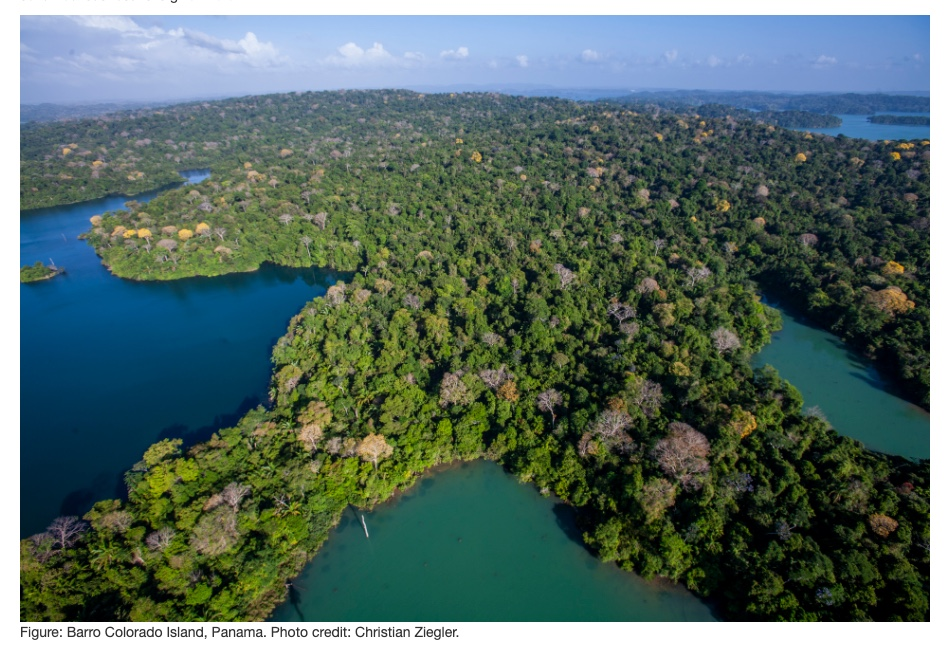

We can plot the census and examine the spatial distribution of our trees. In the plot below, each dot is a tree, colored by its species identity.
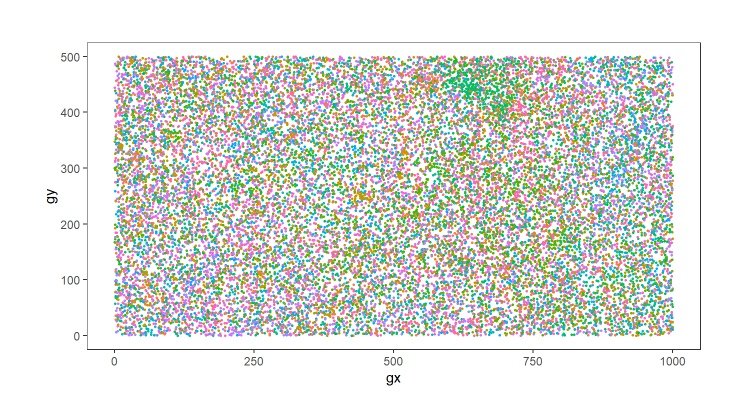


In the plot above, we have ~100 species and thousands of individuals. We may expect species with similar strategies to occur near each other. The question we are asking is whether we can use the BCI censuses to find evidence of ecological similarities between species. 

##Distance-based clustering in species space 

Consider two species, A and B. We measure the distances between every pair of trees of species A and B, and calculate what fraction of these pairs are within a small distance d of each other. By comparing that fraction to the expectation from a Poisson process, we can determine whether species A and B tend to occur near each other more than expected by chance. We chose d = 10m, reflecting the biological assumption of the interaction range between trees. However, tweaking this number in a reasonable range will not significantly change the clustering result.

If the two species tend to be closer to each other we draw a line between them. Notice that every species is connected to some but not all other species.

Also notice that we don't have all the species inside the network. This is because we are restricting the analysis to species with at least 50 individuals in the BCI to make reliable statistical predictions.

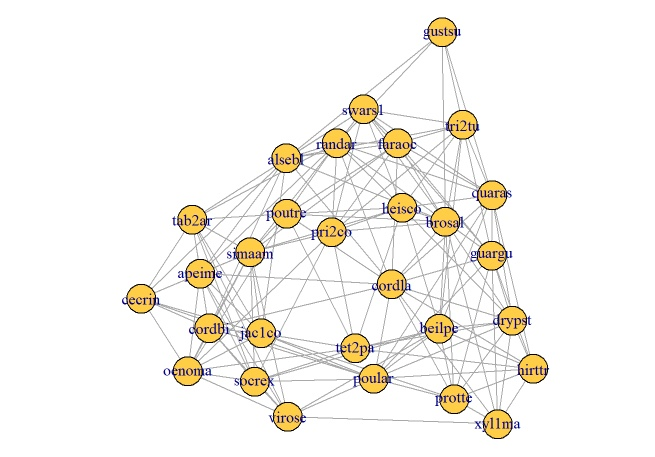

We now ask whether we can find groups of species that are highly connected to each other but not to other species. 


Here we use an algorithm named walk-trap community detection to separate the graph into three groups. The intuition is that short random walks tend to stay in the same community. 


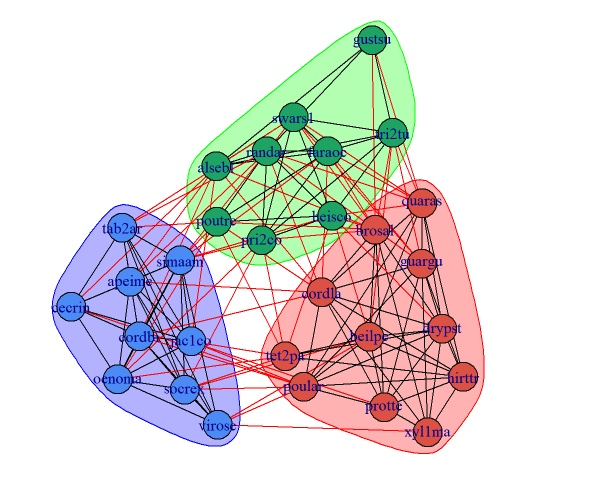

We find three clusters. Our assumptions is that these three clusters of species has different preference/affinity to soil nutrients. Now we can label the original species map using the three clusters we predicted.

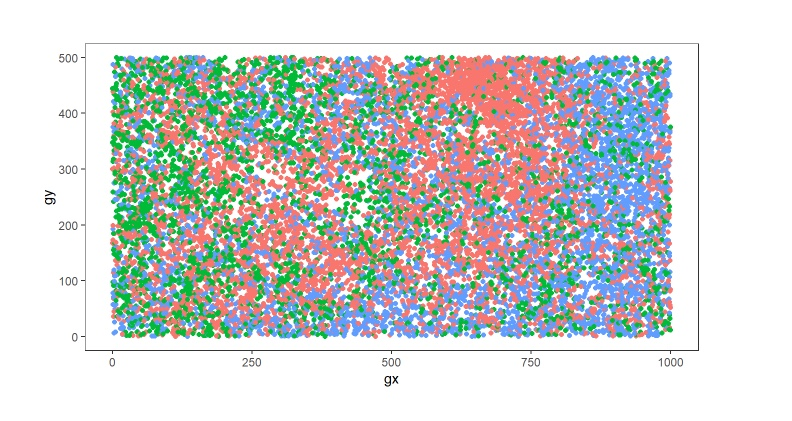

Notice regions of the plot dominated by a single color. This is another way to visually confirm that species in the same group tend to occur near each other.

All of these were done in R, now we read the clustering label from R to Python

In [ ]:
#importing data from clustering result/distance threshold
bci_abd =  pd.read_csv("bci_dis_thresh10_abd0.csv")
bci_abd['abd'] = 0

for i in range(0,450,50):
  foo = pd.read_csv("bci_dis_thresh10_abd"+str(i)+".csv")
  foo['abd'] = i
  bci_abd = bci_abd.append(foo)


abd stands for the abundance threshold for species. i.e. species with abundance lower than the threshold were disgarded


In [ ]:
  bci_abd

,Unnamed: 0,sp,gx,gy,community,nullcommunity,abd
0,1,gustsu,994.099976,488.299988,1,3,0
1,2,virosu,990.500000,488.899994,3,1,0
2,3,quaras,993.500000,498.299988,3,2,0
3,4,protte,992.700012,469.299988,3,2,0
4,5,quaras,983.000000,452.600006,3,2,0
...,...,...,...,...,...,...,...
8875,8876,oenoma,148.929993,197.410004,1,2,400
8876,8877,oenoma,333.820007,334.640015,1,2,400
8877,8878,oenoma,589.830017,482.820007,1,2,400
8878,8879,oenoma,953.739990,122.410004,1,2,400


Kernal density estimation(KDE) is a non-parametric way to estimate the probability density function of a random variable. We use KDE to achieve smoothed distribution of three cluster of species.

In [ ]:
#define the function for kernal density estimation

def kde2D(x, y, bandwidth, xbins=50j, ybins=25j, **kwargs): 
    """Build 2D kernel density estimate (KDE)."""

    # create grid of sample locations (default: 100x100)
    xx, yy = np.mgrid[x.min():x.max():xbins, 
                      y.min():y.max():ybins]

    xy_sample = np.vstack([yy.ravel(), xx.ravel()]).T
    xy_train  = np.vstack([y, x]).T

    kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
    kde_skl.fit(xy_train)

    # score_samples() returns the log-likelihood of the samples
    z = np.exp(kde_skl.score_samples(xy_sample))
    return xx, yy, np.reshape(z, xx.shape)

In [ ]:
from sklearn.neighbors import KernelDensity
import numpy as np
X = np.array([[-1, -1], [-2, -1], [-3, -2], [1, 1], [2, 1], [3, 2]])
kde = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(X)
kde.score_samples(X) 
np.exp(kde.score_samples(xy_sample))

NameError: ignored

In [ ]:
kde_skl = KernelDensity(bandwidth=10)

test = kde_skl.fit(xy_train)
test



KernelDensity(algorithm='auto', atol=0, bandwidth=10, breadth_first=True,
              kernel='gaussian', leaf_size=40, metric='euclidean',
              metric_params=None, rtol=0)

Here we find the best parameters for kernal density estimation using grid search.(which in this case defaults to the log-likelihood):

In [ ]:
xbins=50j
ybins=25j
xx, yy = np.mgrid[x.min():x.max():xbins, 
                      y.min():y.max():ybins]

xy_sample = np.vstack([yy.ravel(), xx.ravel()]).T
xy_train  = np.vstack([y, x]).T

params = {'bandwidth': np.logspace(0.5,2 , 40)}
grid = GridSearchCV(KernelDensity(kernel='gaussian'), params)
grid.fit(xy_train)


KeyboardInterrupt: ignored

In [ ]:
yy.shape

(50, 25)

##plotting the  clusers on the BCI map.

Here we plot the three clusters predicted by distance-based clustering 

In [ ]:
zz.sum(axis=1)

NameError: ignored

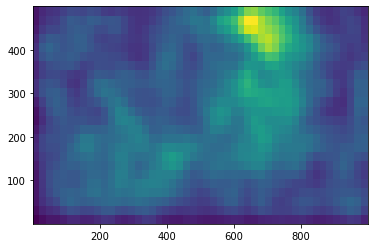

In [ ]:
abd = 50
comm= 1
dt = bci_abd[bci_abd['abd']==abd]
dt_c = dt[dt['community']==comm]
x, y = dt_c["gx"], dt_c["gy"]

xx, yy, zz = kde2D(x, y, 20.0)

plt.pcolormesh(xx, yy, zz)
#plt.scatter(x, y, s=1, facecolor='white')

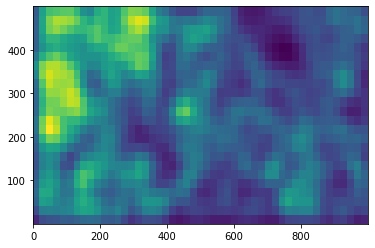

In [ ]:
abd = 50
comm= 2
dt = bci_abd[bci_abd['abd']==abd]
dt_c = dt[dt['community']==comm]
x, y = dt_c["gx"], dt_c["gy"]

xx, yy, zz = kde2D(x, y, 20.0)

plt.pcolormesh(xx, yy, zz)
#plt.scatter(x, y, s=1, facecolor='white')

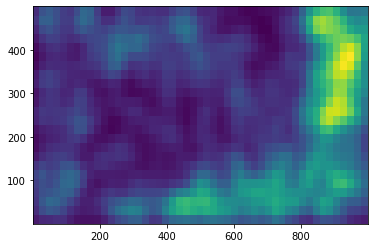

In [ ]:
abd = 50
comm= 3
dt = bci_abd[bci_abd['abd']==abd]
dt_c = dt[dt['community']==comm]
x, y = dt_c["gx"], dt_c["gy"]

xx, yy, zz = kde2D(x, y, 20.0)

plt.pcolormesh(xx, yy, zz)
#plt.scatter(x, y, s=1, facecolor='white')

We see that the spatial distribution of three clusters of species implies the existant of ecological niches.

##Reading soil data


Now we read in the nutrient concentration. We use these nutrientsThe entire map was divided into 1250 quadrats. These data are kriged block estimates for 20 x 20 quadrats in the BCI 50 ha forest dynamics plot 

In [ ]:
soil = pd.read_excel("bci.block20.data.xls")
##look at the soil data set 

soil

,x,y,Al,B,Ca,Cu,Fe,K,Mg,Mn,P,Zn,N,N(min),pH
0,10,10,700.182882,1.289813,2222.990731,7.650088,134.452146,169.251550,347.671739,353.457600,1.101642,3.722908,14.712257,-1.206248,4.653734
1,10,30,767.634698,0.990833,1849.796256,7.138049,121.253268,154.501980,290.658052,262.728425,1.306156,3.517205,14.922783,-1.982044,4.558341
2,10,50,908.544277,0.631111,1293.939229,6.141361,118.903747,141.820146,239.721250,189.711147,1.745696,2.423877,15.462367,-2.443894,4.313436
3,10,70,963.022540,0.545138,1200.332063,5.709103,122.382551,133.607509,226.218068,198.681881,1.967468,2.240394,16.121211,-1.674952,4.167871
4,10,90,944.633527,0.603672,1382.979163,5.805268,130.915369,136.558201,244.079372,254.627093,1.994288,2.353720,17.247879,0.166687,4.202550
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1245,990,410,734.606718,1.652195,2726.034500,9.132962,235.456081,285.780451,466.922819,488.893183,0.717291,10.945226,18.835160,35.735672,4.938133
1246,990,430,664.244065,1.860222,2733.073045,8.487061,235.593080,284.538064,481.337098,481.301108,0.957395,10.440798,19.185343,36.058151,4.946394
1247,990,450,555.558374,1.997975,2983.117648,8.093434,245.434190,315.794670,550.758799,402.077722,1.369720,11.203605,21.024551,37.345414,4.957986
1248,990,470,464.920220,2.087696,3044.292230,7.891383,254.480605,340.159765,606.371897,345.313017,1.654891,10.419794,23.010674,39.000763,4.971663


#plotting soil data

We can, first of all, plot the soil data. Here the yellow color represents higher concentration

In [ ]:
##plotting the N mineralization
soilNmin = soil['N(min)']
soilNmin = soilNmin.to_numpy()
soilNmin_reshaped = np.reshape(soilNmin,(50,25))
#plt.pcolormesh(soilNmin_reshaped.T)
plt.pcolormesh(xx,yy,soilNmin_reshaped)

In [ ]:
##plotting the Al
soilNmin = soil['Al']
soilNmin = soilNmin.to_numpy()
soilNmin_reshaped = np.reshape(soilNmin,(50,25))
#plt.pcolormesh(soilNmin_reshaped.T)
plt.pcolormesh(xx,yy,soilNmin_reshaped)

To verify the biological meaning of our clustering result, we can build a model to predict the clustering reuslt from the distribution of nutrients.

## Preparing species cluster data

In [ ]:
## Preparing species cluster data
def generate_Y(bci_abd, abd):
  dt = bci_abd[bci_abd['abd']==abd]
  dt_c = dt[dt['community']==1]
  x, y = dt_c["gx"], dt_c["gy"]
  xx, yy, zz = kde2D(x, y, 20.0)
  zz = zz.reshape(1250,-1)
  for comm in [2,3]:
    dt = bci_abd[bci_abd['abd']==abd]
    dt_c = dt[dt['community']==comm]
    x, y = dt_c["gx"], dt_c["gy"]
    xx, yy, foo = kde2D(x, y, 20.0)
    foo = foo.reshape(1250,-1)
    zz = np.concatenate((zz, foo), axis=1)
  return zz

In [ ]:
dt = bci_abd[bci_abd['abd']==abd]
dt['community'].values

In [ ]:
## Preparing null data
def generate_Null_Y(bci_abd, abd):
  dt = bci_abd[bci_abd['abd']==abd]
  dt['community'] = np.random.permutation(dt['community'].values)
  dt_c = dt[dt['community']==1]
  x, y = dt_c["gx"], dt_c["gy"]
  xx, yy, zz = kde2D(x, y, 20.0)
  zz = zz.reshape(1250,-1)
  for comm in [2,3]:
    dt = bci_abd[bci_abd['abd']==abd]
    dt_c = dt[dt['community']==comm]
    x, y = dt_c["gx"], dt_c["gy"]
    xx, yy, foo = kde2D(x, y, 20.0)
    foo = foo.reshape(1250,-1)
    zz = np.concatenate((zz, foo), axis=1)
  return zz

In [ ]:
#normalize the probability using l2
Y = generate_Y(bci_abd,50)
#Y=sklearn.preprocessing.normalize(Y, norm='l2', axis=1)

In [ ]:
Y

In [ ]:
Y_Null = generate_Null_Y(bci_abd,50)

#preparing soil data

In [ ]:
#preparing soil data
soil_trimmed = soil.drop(['x', 'y'], axis=1)
X = soil_trimmed.to_numpy().reshape(1250,13)
#X=sklearn.preprocessing.normalize(X, norm='l1', axis=1)

In [ ]:
#shuffle the data set
X, Y = shuffle(X, Y, random_state = 0)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=1/5.0, random_state=0)

In [ ]:
# Let's look at the shape of our data thus far
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

Here we build a Neuro Network with three layers.

In [ ]:
del dense_model

In [ ]:
dense_model = tf.keras.Sequential([
              tf.keras.layers.Dense(13, activation='relu'),
              tf.keras.layers.Dense(6, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.01)),
              tf.keras.layers.Dense(3)])
dense_model.compile(loss=tf.keras.losses.MeanSquaredError(),
                    optimizer='adam',
                    metrics=['mean_squared_error'])


In [ ]:
epochs=60

In [ ]:
dense_history = dense_model.fit(X_train, y_train, epochs=epochs, validation_split=0.2, verbose=0)

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(range(epochs), dense_history.history['mean_squared_error'], label='Train')
ax.plot(range(epochs), dense_history.history['val_mean_squared_error'], label='Validation')
ax.set(title='Epochs vs. Mean Squared Error', xlabel='Epoch', ylabel='Mean Squared Error')
ax.legend()

In [ ]:
dense_cost = dense_model.evaluate(X_test, y_test)[0]

We achieve great accuracy! This proves that our species clustering result does encompass spatial preference of plants.

Now we try run the same neuro net structure on the null model, to prove that this accuracy isn't a fluke

In [ ]:
del dense_Null_model

In [ ]:
Y_Null

In [ ]:
#shuffle the data set
X_Null,Y_Null= shuffle(X,Y_Null,random_state = 1)
#Y_Null = shuffle(Y, random_state = 2)

X_Null_train, X_Null_test, Y_Null_train, Y_Null_test = train_test_split(
    X_Null, Y_Null, test_size=1/5.0, random_state=0)

In [ ]:
dense_Null_model = tf.keras.Sequential([
              tf.keras.layers.Dense(13, activation='relu'),
              tf.keras.layers.Dense(6, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.01)),
              tf.keras.layers.Dense(3)])
dense_Null_model.compile(loss=tf.keras.losses.MeanSquaredError(),
                    optimizer='adam',
                    metrics=['mean_squared_error'])


In [ ]:
dense_Null_history = dense_Null_model.fit(X_Null_train, Y_Null_train, epochs=60, validation_split=0.2, verbose=0)

In [ ]:

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(range(60), dense_Null_history.history['mean_squared_error'], label='Train')
ax.plot(range(60), dense_Null_history.history['val_mean_squared_error'], label='Validation')
ax.set(title='Epochs vs. Mean Squared Error', xlabel='Epoch', ylabel='Mean Squared Error')
ax.legend()

In [ ]:
dense_cost = dense_Null_model.evaluate(X_Null_test, Y_Null_test)[0]

In [ ]:
dense_cost = dense_Null_model.evaluate(X_test, y_test)[0]

The fact that we get much lower accuracy on the null model proves that our clustering method does capture the ecological niche of the species.

#can we achieve high accuracy with a simpler model?

This neuro net with less neurons perform better:

In [ ]:
del dense_simple_model

In [ ]:
dense_simple_model = tf.keras.Sequential([
              tf.keras.layers.Dense(13, activation='relu'),
              tf.keras.layers.Dense(1, activation='relu'), 
              tf.keras.layers.Dense(3)])
dense_simple_model.compile(loss=tf.keras.losses.MeanSquaredError(),
                    optimizer='adam',
                    metrics=['mean_squared_error'])


In [ ]:
dense_simple_history = dense_simple_model.fit(X_train, y_train, epochs=60, validation_split=0.2, verbose=0)

In [ ]:
dense_cost = dense_simple_model.evaluate(X_test, y_test)[0]

#trait data

##import r packages

In [ ]:
import rpy2.robjects.packages as rpackages

##Linear model does not perform well

In [ ]:
model = sklearn.linear_model.Ridge()
model.fit(X_train, y_train)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [ ]:
linear_prediction = model.predict(X_test)
linear_cost = cohen_kappa_score(linear_prediction, y_test)
print(f'Test Mean Squared Error for Linear Model = {linear_cost}')


ValueError: ignored

In [ ]:
Null_model = sklearn.linear_model.Ridge()
Null_model.fit(X_Null_train, Y_Null_train)

In [ ]:
linear_prediction = Null_model.predict(X_test)
linear_cost = sklearn.metrics.mean_squared_error(linear_prediction, y_test)
print(f'Test Mean Squared Error for Linear Model = {linear_cost}')


## import trait data

In [ ]:
ls

bci.block20.data.xls  bci_dis29.csv  bci_dis_thresh10_abd0.csv
bci_dis10.csv         bci_dis2.csv   bci_dis_thresh10_abd100.csv
bci_dis11.csv         bci_dis30.csv  bci_dis_thresh10_abd10.csv
bci_dis12.csv         bci_dis31.csv  bci_dis_thresh10_abd150.csv
bci_dis13.csv         bci_dis32.csv  bci_dis_thresh10_abd200.csv
bci_dis14.csv         bci_dis33.csv  bci_dis_thresh10_abd20.csv
bci_dis15.csv         bci_dis34.csv  bci_dis_thresh10_abd250.csv
bci_dis16.csv         bci_dis35.csv  bci_dis_thresh10_abd300.csv
bci_dis17.csv         bci_dis36.csv  bci_dis_thresh10_abd30.csv
bci_dis18.csv         bci_dis37.csv  bci_dis_thresh10_abd350.csv
bci_dis19.csv         bci_dis38.csv  bci_dis_thresh10_abd400.csv
bci_dis20.csv         bci_dis39.csv  bci_dis_thresh10_abd40.csv
bci_dis21.csv         bci_dis3.csv   bci_dis_thresh10_abd50.csv
bci_dis22.csv         bci_dis40.csv  bci_dis_thresh10_abd60.csv
bci_dis23.csv         bci_dis4.csv   bci_dis_thresh10_abd70.csv
bci_dis24.csv         bci_dis5.csv

In [ ]:
traits = pd.read_excel("BCITRAITS_20101220.xlsx")
traits['SP$'] = traits['SP$'].str.lower()
traits

,GENUS$,SPECIES$,FAMILY$,GRWFRM2$,GRWFRM1$,SP$,SG60C_AVG,SG100C_AVG,SG60C_SEM,SG100C_SEM,SG60C_N,SG100C_N,WSG_CHAVE,FRUIT_FRSH,FRUIT_DRY,N_SEEDFULL,N_SEEDEMPTY,DSPR_FRESH,DSPR_DRY,SEED_FRESH,SEED_DRY,N_INDS,N_FRUIT,N_DIASPORE,N_SEEDS,DAWS_DSPRDRY,DBH_AVG,HEIGHT_AVG,DIAM_AVG,DBH_SEM,HEIGHT_SEM,DIAM_SEM,DBH_N,HEIGHT_N,DIAM_N,LEAFAREA_AVD,LEAFLET_AVD,LEAFTHCK_AVD,LMADISC_AVD,LMALEAF_AVD,...,LEAFAREA_AVI,LEAFLET_AVI,LEAFTHCK_AVI,LMADISC_AVI,LMALEAF_AVI,LMALAM_AVI,LDDISC_AVI,LDMC_AVI,LEAFAREA_SEI,LEAFLET_SEI,LEAFTHCK_SEI,LMADISC_SEI,LMALEAF_SEI,LMALAM_SEI,LDDISC_SEI,LDMC_SEI,LEAFAREA_NI,LEAFLET_NI,LEAFTHCK_NI,LMADISC_NI,LMALEAF_NI,LMALAM_NI,LDDISC_NI,LDMC_NI,AVG_LAMTUF,AVG_VEINTUF,SEM_LAMTUF,SEM_VEINTUF,N_LAMTUF,N_VEINTUF,RGR_10,N_RGR10,RGR_50,N_RGR50,RGR_100,N_RGR100,MORT_10,N_MORT10,MORT_100,N_MORT100
0,Abuta,racemosa,Menispermace,Climber,Climber,abutra,0.467003,0.497156,NaN,0.011792,1.0,5.0,NaN,2.298373,0.385727,1.000000,0.000000,0.620088,0.177257,0.113248,0.035177,3.0,15.0,21.0,21.0,0.579,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26.635556,NaN,188.055556,74.848281,79.241870,...,46.655000,NaN,172.500000,55.967633,65.775687,61.771450,0.324972,0.445444,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,699.375000,4000.475000,23.716147,317.933922,4.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Acacia,hayesii,Fabaceae,Climber,Climber,acacha,0.367613,0.385289,NaN,0.018961,1.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,144.530000,NaN,133.333333,NaN,114.057385,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Acacia,melanoceras,Fabaceae:Mim,U,U,acacme,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,60.400000,10.608000,2.131607,14.551976,1.250589,0.287179,5.0,5.0,5.0,NaN,NaN,NaN,NaN,NaN,...,110.479375,43.666667,74.375000,NaN,50.326072,46.778648,NaN,0.336027,9.745738,2.657275,4.835462,NaN,5.107573,6.823786,NaN,0.014889,8.0,6.0,8.0,0.0,8.0,3.0,0.0,8.0,NaN,NaN,NaN,NaN,NaN,NaN,3.240040,25.0,2.476286,7.0,0.909333,6.0,0.000000,34.0,6.628800,10.0
3,Acalypha,diversifolia,Euphorbiacea,S,S,acaldi,0.513612,0.501292,0.028780,0.029164,4.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,65.666667,6.260000,2.467500,2.185813,0.657597,0.157500,3.0,3.0,2.0,NaN,NaN,NaN,NaN,NaN,...,69.437222,NaN,161.111111,41.563647,45.880065,43.636421,0.260478,0.329436,5.272158,NaN,9.503086,1.898919,2.003435,1.891617,0.013190,0.010461,6.0,0.0,6.0,6.0,6.0,6.0,6.0,6.0,477.860000,2115.560000,42.714315,151.974062,10.0,10.0,3.436354,2177.0,1.647479,192.0,0.470167,6.0,8.440188,4579.0,10.742364,11.0
4,Acalypha,macrostachya,Euphorbiacea,U,U,acalma,0.411337,0.404128,0.022054,0.021682,5.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,48.800000,7.080000,2.212857,5.571355,0.472959,0.411906,5.0,5.0,4.0,210.473333,NaN,128.333333,26.522814,38.765081,...,118.092222,NaN,189.444444,30.393846,33.947601,27.839281,0.165260,0.210596,12.270496,NaN,16.132648,3.042018,2.755671,2.517004,0.014204,0.011443,9.0,0.0,9.0,9.0,9.0,9.0,9.0,9.0,198.409091,1613.981818,17.659576,173.727106,11.0,11.0,4.078495,95.0,2.258881,42.0,2.433500,2.0,12.021158,265.0,7.252000,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
618,Zanthoxylum,panamense,Rutaceae,T,T,zantp1,0.559951,0.552063,0.038199,0.037734,5.0,5.0,0.490000,0.022570,0.012950,1.000000,0.000000,0.012130,0.007950,0.002060,0.001300,2.0,10.0,10.0,10.0,0.029,447.333333,28.221248,6.614917,20.157160,1.501852,0.325861,6.0,6.0,5.0,365.170000,8.000000,296.500000,94.021128,113.711422,...,267.298333,8.972222,164.305556,38.360680,55.120018,37.903088,0.232364,0.

In [ ]:
abd = 50
dt = bci_abd[bci_abd['abd']==abd]



In [ ]:
bci_communities = dt.drop_duplicates(subset = 'sp')
bci_communities

,Unnamed: 0,sp,gx,gy,community,nullcommunity,abd
0,1,gustsu,994.099976,488.299988,1,2,50
1,2,virosu,990.500000,488.899994,3,2,50
2,3,quaras,993.500000,498.299988,1,1,50
3,4,protte,992.700012,469.299988,3,2,50
5,6,tri2tu,991.599976,431.799988,1,1,50
...,...,...,...,...,...,...,...
3397,3398,eugeoe,843.700012,57.700001,1,1,50
3421,3422,ingama,859.500000,117.699997,2,1,50
3766,3767,ingasa,941.099976,363.200012,2,1,50
3843,3844,cou2cu,923.000000,31.500000,1,2,50


Merge features

In [ ]:
dt_merged = pd.merge(bci_communities, traits,left_on='sp', right_on='SP$')
dt_merged

,Unnamed: 0,sp,gx,gy,community,nullcommunity,abd,GENUS$,SPECIES$,FAMILY$,GRWFRM2$,GRWFRM1$,SP$,SG60C_AVG,SG100C_AVG,SG60C_SEM,SG100C_SEM,SG60C_N,SG100C_N,WSG_CHAVE,FRUIT_FRSH,FRUIT_DRY,N_SEEDFULL,N_SEEDEMPTY,DSPR_FRESH,DSPR_DRY,SEED_FRESH,SEED_DRY,N_INDS,N_FRUIT,N_DIASPORE,N_SEEDS,DAWS_DSPRDRY,DBH_AVG,HEIGHT_AVG,DIAM_AVG,DBH_SEM,HEIGHT_SEM,DIAM_SEM,DBH_N,...,LEAFAREA_AVI,LEAFLET_AVI,LEAFTHCK_AVI,LMADISC_AVI,LMALEAF_AVI,LMALAM_AVI,LDDISC_AVI,LDMC_AVI,LEAFAREA_SEI,LEAFLET_SEI,LEAFTHCK_SEI,LMADISC_SEI,LMALEAF_SEI,LMALAM_SEI,LDDISC_SEI,LDMC_SEI,LEAFAREA_NI,LEAFLET_NI,LEAFTHCK_NI,LMADISC_NI,LMALEAF_NI,LMALAM_NI,LDDISC_NI,LDMC_NI,AVG_LAMTUF,AVG_VEINTUF,SEM_LAMTUF,SEM_VEINTUF,N_LAMTUF,N_VEINTUF,RGR_10,N_RGR10,RGR_50,N_RGR50,RGR_100,N_RGR100,MORT_10,N_MORT10,MORT_100,N_MORT100
0,1,gustsu,994.099976,488.299988,1,2,50,Gustavia,superba,Lecythidacea,M,M,gustsu,0.603363,0.612492,0.015698,0.012126,7.0,4.0,0.579633,303.669090,107.036985,11.801587,2.436508,14.237050,6.042451,13.109680,5.661719,9.0,25.0,100.0,100.0,2.815,403.000000,20.570104,4.282793,10.885771,0.999090,0.680803,5.0,...,175.892500,NaN,153.055556,44.691691,55.193691,52.473080,0.290705,0.262537,31.415197,NaN,8.969255,3.723955,4.950322,4.926514,0.011016,0.011168,6.0,0.0,6.0,6.0,6.0,6.0,6.0,6.0,809.847059,3244.725000,332.784849,182.226245,17.0,16.0,3.171343,134.0,0.849488,502.0,0.452798,3025.0,2.453012,855.0,0.579736,3207.0
1,2,virosu,990.500000,488.899994,3,2,50,Virola,surinamensis,Myristicacea,T,T,virosu,0.383251,0.407319,0.034080,0.036372,2.0,3.0,0.416009,15.248587,4.577899,1.000000,0.000000,3.363653,2.215282,2.252516,1.580256,9.0,49.0,49.0,25.0,1.952,858.000000,37.272328,7.590143,33.713499,2.384359,0.161218,5.0,...,157.314000,NaN,171.833333,49.539222,57.462886,55.770514,0.289342,0.280287,33.646110,NaN,6.326751,3.215738,2.969252,2.889337,0.019590,0.005842,5.0,0.0,5.0,5.0,5.0,5.0,5.0,5.0,350.000000,2168.608333,32.516947,168.496581,12.0,12.0,2.736978,178.0,1.605094,170.0,1.424464,601.0,3.365947,418.0,2.014498,825.0
2,3,quaras,993.500000,498.299988,1,1,50,Quararibea,asterolepis,Bombacaceae,NaN,T,quaras,0.558785,0.468115,0.015583,0.033083,2.0,5.0,0.453960,4.993971,1.258512,1.602857,0.217143,0.792974,0.321729,0.210806,0.079972,5.0,32.0,71.0,37.0,NaN,934.333333,33.493370,6.274246,30.339926,1.030341,0.608570,6.0,...,94.917222,NaN,180.000000,47.838466,50.554808,48.935755,0.267650,0.291754,20.863593,NaN,13.228757,1.224828,1.743246,1.796461,0.013470,0.001949,3.0,0.0,3.0,3.0,3.0,3.0,3.0,3.0,466.276471,2930.235294,33.353852,117.831958,17.0,17.0,1.766322,5202.0,1.232564,1884.0,0.929572,2585.0,1.421807,8064.0,1.225062,3535.0
3,4,protte,992.700012,469.299988,3,2,50,Protium,tenuifolium,Burseraceae,M,M,protte,0.595889,0.586264,0.019915,0.015440,4.0,5.0,0.570291,4.657143,1.145760,2.428571,0.685714,0.404341,0.192849,0.166455,0.098637,7.0,35.0,73.0,60.0,1.300,396.833333,20.482320,5.664821,40.548257,1.775873,0.523137,6.0,...,588.635000,5.583333,187.083333,59.901101,83.504675,68.728548,0.331809,0.414863,106.213026,0.688194,12.523589,4.934192,9.634629,7.488312,0.042000,0.021539,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,618.453846,5159.546154,44.397946,461.406928,13.0,13.0,2.161820,9144.0,1.502480,1490.0,0.814889,1575.0,1.566259,12404.0,1.680846,1830.0
4,6,tri2tu,991.599976,431.799988,1,1,50,Trichilia,tuberculata,Meliaceae,T,T,tri2tu,0.665530,0.691553,0.000128,0.068229,2.0,5.0,0.627189,1.493470,0.521049,1.700000,0.025000,0.278668,0.134250,0.181655,0.109507,8.0,50.0,110.0,83.0,0.151,601.666667,29.346727,6.051033,12.563616,0.930539,0.686937,6.0,...,229.644667,7.266667,179.000000,57.833221,73.021853,61.359181,0.323741,0.356269,20.625024,0.250555,7.850159,2.028725,2.358904,2.107263,0.006596,0.011299,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,355.055556,2469.116667,26.452907,148.074487,18.0,18.0,1.682515,39142.0,0.917909,7172.0,0.794063,7592.0,2.380429,55188.0,2.660780,8952.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,..

##seperate the traits into five independent category：size, leaf, seed, woods and vital

In [ ]:
#size traits consist "DBH_AVG", "HEIGHT_AVG", "DIAM_AVG"
dt_size_traits = dt_merged[["sp","community",
      "DBH_AVG", 
      "HEIGHT_AVG", 
      "DIAM_AVG"
    ]]
dt_leaf_traits = dt_merged[["sp","community",
      "DBH_AVG", 
       "LEAFAREA_AVD",
      "LEAFTHCK_AVD",
      "LMADISC_AVD",
      "LMALEAF_AVD",
      "LMALAM_AVD",
      "LDDISC_AVD",
      "LDMC_AVD",
      "LEAFAREA_AVI",
      "LEAFTHCK_AVI",
      "LMADISC_AVI",
      "LMALEAF_AVI",
      "LMALAM_AVI" ,
      "LDDISC_AVI" ,
      "LDMC_AVI"  ,
      "AVG_LAMTUF" ,
      "AVG_VEINTUF"
    ]]
dt_seed_traits = dt_merged[["sp","community",
       "FRUIT_FRSH",
      "FRUIT_DRY" ,
      "DSPR_FRESH",
      "DSPR_DRY",
      "SEED_FRESH",
      "SEED_DRY"
    ]]
dt_wood_traits = dt_merged[["sp","community",
     "SG60C_AVG",
      "SG100C_AVG" 
    ]]
dt_vital_traits = dt_merged[["sp","community",
      "RGR_10",      
      "RGR_50",
      "RGR_100",
      "MORT_10",
      "MORT_100"
    ]]

In [ ]:
df = pd.merge(dt_size_traits.drop(['community'], axis=1), dt_leaf_traits.drop(['community'], axis=1), how='inner', on='sp')
df = pd.merge(df, dt_seed_traits.drop(['community'], axis=1), how='inner', on='sp')
df = pd.merge(df, dt_wood_traits.drop(['community'], axis=1), how='inner', on='sp')
df = pd.merge(df, dt_vital_traits.drop(['community'], axis=1), how='inner', on='sp')

In [ ]:
df_x = df.drop(['sp'], axis=1)
for (columnName, columnData)  in df_x.iteritems():
    df_x.update(df_x[str(columnName)].fillna(value=df_x[str(columnName)].mean(), inplace=True))  


In [ ]:
def pcaplot(traits,cutoff=2,n_components=1):
  #keep only the traits
  traits =  traits[traits.columns[cutoff:]]
  ##replace NA with mean
  for (columnName, columnData)  in traits.iteritems():
    traits.update(traits[str(columnName)].fillna(value=traits[str(columnName)].mean(), inplace=True))  
  pca = PCA().fit(traits)
  plt.plot(np.cumsum(pca.explained_variance_ratio_))
  plt.xlim(0, 5)
  plt.xlabel('number of components')
  plt.ylabel('cumulative explained variance');
  pca = PCA(n_components=n_components)
  pca.fit(traits)
  X_pca = pca.transform(traits)
  
  return X_pca

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:4536: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:4536: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:4536: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,
/usr/local/lib/python3.7/dist-packages/pand

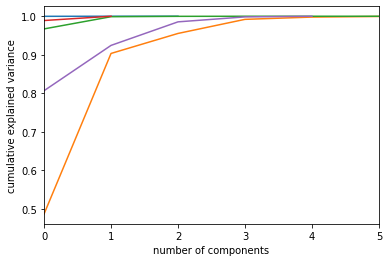

In [ ]:
pca_size_traits=pcaplot(dt_size_traits)
pca_leaf_traits = pcaplot(dt_leaf_traits)
pca_seed_traits =  pcaplot(dt_seed_traits)
pca_wood_traits=pcaplot(dt_wood_traits)
pca_vital_traits=pcaplot(dt_vital_traits)


In [ ]:
pca_vital_traits.shape

(65, 1)

In [ ]:
traits_pca = np.concatenate((pca_size_traits,pca_leaf_traits,pca_seed_traits,pca_wood_traits,pca_vital_traits),axis=1)


In [ ]:
##generate Y
group_replaced= dt_merged['community']
ohe = OneHotEncoder()
ohe.fit(group_replaced.to_numpy().reshape(-1,1))
group = ohe.transform(group_replaced.to_numpy().reshape(-1,1)).toarray()


In [ ]:
##shuffle the data set
X, Y = shuffle(traits_pca, group, random_state = 2)
#X, Y = shuffle(df_x, group, random_state = 0)
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=1/5.0, random_state=0)
# Let's look at the shape of our data thus far
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

X_train shape: (52, 5)
X_test shape: (13, 5)
y_train shape: (52, 3)
y_test shape: (13, 3)


In [ ]:
##NULL data set
'''X_Null =  shuffle(traits_pca,random_state = 1)
Y_Null =  shuffle(group,random_state = 2)

X_train, X_test, y_train, y_test = train_test_split(
    X_Null, Y_Null, test_size=1/5.0, random_state=0)
# Let's look at the shape of our data thus far
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)'''

"X_Null =  shuffle(traits_pca,random_state = 1)\nY_Null =  shuffle(group,random_state = 2)\n\nX_train, X_test, y_train, y_test = train_test_split(\n    X_Null, Y_Null, test_size=1/5.0, random_state=0)\n# Let's look at the shape of our data thus far\nprint('X_train shape:', X_train.shape)\nprint('X_test shape:', X_test.shape)\nprint('y_train shape:', y_train.shape)\nprint('y_test shape:', y_test.shape)"

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import make_classification
from sklearn.metrics import cohen_kappa_score, make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV


##Random Forest

In [ ]:
#Random Forest Classifier
rf = RandomForestClassifier(max_depth=1,random_state=4)
rf.fit(X_train, y_train[:,0]+y_train[:,1]*2+y_train[:,2]*3)
print(cohen_kappa_score(y_test[:,0]+y_test[:,1]*2+y_test[:,2]*3,rf.predict(X_test)))


0.4747474747474748


In [ ]:
rf.predict(X_test)

array([1., 1., 1., 2., 2., 1., 1., 1., 1., 2., 1., 1., 2.])

In [ ]:
y_test[:,0]+y_test[:,1]*2+y_test[:,2]*3

array([1., 1., 3., 2., 2., 3., 1., 1., 1., 2., 1., 2., 3.])

In [ ]:
# Look at parameters used by our current forest
print('Parameters currently in use:\n')
print(rf.get_params())


Parameters currently in use:

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 1, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 4, 'verbose': 0, 'warm_start': False}


In [ ]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)
{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}

In [ ]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
clf = RandomForestClassifier(random_state=0)
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = clf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train[:,0]+y_train[:,1]*2+y_train[:,2]*3)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   43.9s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  5.7min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [ ]:
rf_random.best_params_

NameError: ignored

In [ ]:
best_random = rf_random.best_estimator_
best_random.predict(X_test)

array([1., 1., 1., 1., 1., 2., 1., 1., 1., 2., 1., 1., 1.])

In [ ]:
def onehot_to_integer(y_test):
  return y_test[:,0]+y_test[:,1]*2+y_test[:,2]*3

In [ ]:
cohen_kappa_score(y_test[:,0]+y_test[:,1]*2+y_test[:,2]*3, best_random.predict(X_test))

0.17894736842105274

In [ ]:
kappa_scorer = make_scorer(cohen_kappa_score)
# Create the parameter grid based on the results of random search 
param_grid = {
    #'bootstrap': [False,True],
    'max_depth': [1,2,3,4,5,6,7,8 ],
    'max_features': [2, 3,4,5,10],
    'min_samples_leaf': [2,3,4, 5],
    #'min_samples_split': [4, 8, 10, 12],
    #'n_estimators': [10,100,200]
}
# Create a based model
rf = RandomForestClassifier(random_state=0)
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid,cv=3,
                          n_jobs = -1, verbose = 2, scoring=kappa_scorer)

In [ ]:
grid_search.fit(X_train, y_train[:,0]+y_train[:,1]*2+y_train[:,2]*3)


Fitting 3 folds for each of 160 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 252 tasks      | elapsed:   26.8s
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed:   50.6s finished


GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False, random_state=0,
                                   

In [ ]:
print(grid_search.best_params_)
print('best_score=',grid_search.best_score_)
best_grid = grid_search.best_estimator_


{'max_depth': 1, 'max_features': 2, 'min_samples_leaf': 5}
best_score= 0.19737827715355807


In [ ]:
cohen_kappa_score(best_grid.predict(X_test),y_test[:,0]+y_test[:,1]*2+y_test[:,2]*3)

0.4747474747474747

In [ ]:
(clf.predict(X_test)==(y_test[:,0]+y_test[:,1]*2+y_test[:,2]*3)).mean()

NameError: ignored

##Gradient Boosting

In [ ]:
#Random Forest Classifier
gb = GradientBoostingClassifier(max_depth=1,random_state=1,learning_rate=0.01)
gb.fit(X_train, y_train[:,0]+y_train[:,1]*2+y_train[:,2]*3)
print(cohen_kappa_score(y_test[:,0]+y_test[:,1]*2+y_test[:,2]*3,gb.predict(X_test)))


0.17894736842105274


In [ ]:
#Gradietboosting
kappa_scorer = make_scorer(cohen_kappa_score)
# Create the parameter grid based on the results of random search 
param_grid = {
    #'bootstrap': [False,True],
    'max_depth': [1,2,3,4,5],
    'loss': ['deviance','exponential'],
    'max_features': [2,4,5,10],
     #'min_samples_leaf': [2,3,4,5],
     'learning_rate' : [0.001,0.01,0.05,0.1],
    #'min_samples_split': [4, 8, 10, 12],
    'n_estimators': [10,100,200]
}
# Create a based model
gb = GradientBoostingClassifier(random_state=0)
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = gb, param_grid = param_grid,cv=,
                          n_jobs = -1, verbose = 2, scoring=kappa_scorer)
grid_search.fit(X_train, y_train[:,0]+y_train[:,1]*2+y_train[:,2]*3)


Fitting 3 folds for each of 960 candidates, totalling 2880 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 454 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 2880 out of 2880 | elapsed:    4.6s finished


ValueError: ignored

In [ ]:
print(grid_search.best_params_)
print(grid_search.best_score_)
best_grid = grid_search.best_estimator_
cohen_kappa_score(best_grid.predict(X_test),y_test[:,0]+y_test[:,1]*2+y_test[:,2]*3)

{'learning_rate': 0.001, 'loss': 'deviance', 'max_depth': 4, 'max_features': 5, 'n_estimators': 100}
0.22079272540877068


-0.07216494845360821

In [ ]:
dense_Null = tf.keras.Sequential([
              tf.keras.layers.Dense(5, activation='relu'),
              tf.keras.layers.Dropout(0.2),
              tf.keras.layers.Dense(3,activation='softmax')])
dense_Null.compile(loss=kappa_loss, optimizer='adam')

In [ ]:
del dense_simple_model

In [ ]:
dense_Null_history = dense_Null.fit(X_Null, Y_Null, epochs=20, validation_batch_size = 0.2,verbose=1)

Epoch 1/20
3/3 [==============================] - 0s 3ms/step - loss: 0.6351
Epoch 2/20
3/3 [==============================] - 0s 2ms/step - loss: 0.9523
Epoch 3/20
3/3 [==============================] - 0s 3ms/step - loss: 0.9290
Epoch 4/20
3/3 [==============================] - 0s 7ms/step - loss: 0.9421
Epoch 5/20
3/3 [==============================] - 0s 3ms/step - loss: 0.9138
Epoch 6/20
3/3 [==============================] - 0s 3ms/step - loss: 0.9207
Epoch 7/20
3/3 [==============================] - 0s 4ms/step - loss: 0.9391
Epoch 8/20
3/3 [==============================] - 0s 4ms/step - loss: 0.8858
Epoch 9/20
3/3 [==============================] - 0s 3ms/step - loss: 0.9225
Epoch 10/20
3/3 [==============================] - 0s 4ms/step - loss: 0.9005
Epoch 11/20
3/3 [==============================] - 0s 4ms/step - loss: 0.8810
Epoch 12/20
3/3 [==============================] - 0s 3ms/step - loss: 0.9500
Epoch 13/20
3/3 [==============================] - 0s 4ms/step - loss: 0.

In [ ]:
from sklearn.metrics import cohen_kappa_score
dense_simple_model = tf.keras.Sequential([
              tf.keras.layers.Dense(8, activation='relu'),
              tf.keras.layers.Dropout(0.2),
              tf.keras.layers.Dense(3,activation='softmax')])
dense_simple_model.compile(loss=kappa_loss, optimizer='adam')

In [ ]:
dense_simple_history = dense_simple_model.fit(X_train, y_train, epochs=8, validation_batch_size = 0.2,verbose=1)

Epoch 1/8
2/2 [==============================] - 0s 4ms/step - loss: 0.8481
Epoch 2/8
2/2 [==============================] - 0s 6ms/step - loss: 0.8408
Epoch 3/8
2/2 [==============================] - 0s 3ms/step - loss: 0.8260
Epoch 4/8
2/2 [==============================] - 0s 3ms/step - loss: 0.7802
Epoch 5/8
2/2 [==============================] - 0s 4ms/step - loss: 0.7398
Epoch 6/8
2/2 [==============================] - 0s 4ms/step - loss: 0.7560
Epoch 7/8
2/2 [==============================] - 0s 6ms/step - loss: 0.8197
Epoch 8/8
2/2 [==============================] - 0s 4ms/step - loss: 0.7276


In [ ]:
cohen_kappa_score(onehot_to_integer(np.around(dense_simple_model.predict(X_train))), onehot_to_integer(y_train))

0.07188894397620227

In [ ]:
y_test

array([[1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [ ]:
 onehot_to_integer(y_test)

array([1., 1., 3., 2., 2., 3., 1., 1., 1., 2., 1., 2., 3.])

In [ ]:
np.around(dense_simple_model.predict(X_train))

array([[0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0

In [ ]:
result =  onehot_to_integer(np.around(dense_simple_model.predict(X_test)))
result 

array([1., 2., 1., 2., 1., 1., 1., 1., 1., 1., 2., 1., 1.], dtype=float32)

In [ ]:
dt_merged_dropfeatures = dt_merged.dropna(axis=1, thresh=len(dt_merged)-32)##drop features with more than half NAs
dt_merged_dropfeatures

,Unnamed: 0,sp,gx,gy,community,nullcommunity,abd,GENUS$,SPECIES$,FAMILY$,GRWFRM2$,GRWFRM1$,SP$,SG60C_AVG,SG100C_AVG,SG60C_SEM,SG100C_SEM,SG60C_N,SG100C_N,WSG_CHAVE,FRUIT_FRSH,FRUIT_DRY,N_SEEDFULL,N_SEEDEMPTY,DSPR_FRESH,DSPR_DRY,SEED_FRESH,SEED_DRY,N_INDS,N_FRUIT,N_DIASPORE,N_SEEDS,DBH_AVG,HEIGHT_AVG,DIAM_AVG,DBH_SEM,HEIGHT_SEM,DIAM_SEM,DBH_N,HEIGHT_N,...,LDDISC_ND,LDMC_ND,LEAFAREA_AVI,LEAFTHCK_AVI,LMADISC_AVI,LMALEAF_AVI,LMALAM_AVI,LDDISC_AVI,LDMC_AVI,LEAFAREA_SEI,LEAFTHCK_SEI,LMADISC_SEI,LMALEAF_SEI,LMALAM_SEI,LDDISC_SEI,LDMC_SEI,LEAFAREA_NI,LEAFLET_NI,LEAFTHCK_NI,LMADISC_NI,LMALEAF_NI,LMALAM_NI,LDDISC_NI,LDMC_NI,AVG_LAMTUF,AVG_VEINTUF,SEM_LAMTUF,SEM_VEINTUF,N_LAMTUF,N_VEINTUF,RGR_10,N_RGR10,RGR_50,N_RGR50,RGR_100,N_RGR100,MORT_10,N_MORT10,MORT_100,N_MORT100
0,1,gustsu,994.099976,488.299988,1,2,50,Gustavia,superba,Lecythidacea,M,M,gustsu,0.603363,0.612492,0.015698,0.012126,7.0,4.0,0.579633,303.669090,107.036985,11.801587,2.436508,14.237050,6.042451,13.109680,5.661719,9.0,25.0,100.0,100.0,403.000000,20.570104,4.282793,10.885771,0.999090,0.680803,5.0,5.0,...,4.0,0.0,175.892500,153.055556,44.691691,55.193691,52.473080,0.290705,0.262537,31.415197,8.969255,3.723955,4.950322,4.926514,0.011016,0.011168,6.0,0.0,6.0,6.0,6.0,6.0,6.0,6.0,809.847059,3244.725000,332.784849,182.226245,17.0,16.0,3.171343,134.0,0.849488,502.0,0.452798,3025.0,2.453012,855.0,0.579736,3207.0
1,2,virosu,990.500000,488.899994,3,2,50,Virola,surinamensis,Myristicacea,T,T,virosu,0.383251,0.407319,0.034080,0.036372,2.0,3.0,0.416009,15.248587,4.577899,1.000000,0.000000,3.363653,2.215282,2.252516,1.580256,9.0,49.0,49.0,25.0,858.000000,37.272328,7.590143,33.713499,2.384359,0.161218,5.0,5.0,...,4.0,2.0,157.314000,171.833333,49.539222,57.462886,55.770514,0.289342,0.280287,33.646110,6.326751,3.215738,2.969252,2.889337,0.019590,0.005842,5.0,0.0,5.0,5.0,5.0,5.0,5.0,5.0,350.000000,2168.608333,32.516947,168.496581,12.0,12.0,2.736978,178.0,1.605094,170.0,1.424464,601.0,3.365947,418.0,2.014498,825.0
2,3,quaras,993.500000,498.299988,1,1,50,Quararibea,asterolepis,Bombacaceae,NaN,T,quaras,0.558785,0.468115,0.015583,0.033083,2.0,5.0,0.453960,4.993971,1.258512,1.602857,0.217143,0.792974,0.321729,0.210806,0.079972,5.0,32.0,71.0,37.0,934.333333,33.493370,6.274246,30.339926,1.030341,0.608570,6.0,6.0,...,6.0,5.0,94.917222,180.000000,47.838466,50.554808,48.935755,0.267650,0.291754,20.863593,13.228757,1.224828,1.743246,1.796461,0.013470,0.001949,3.0,0.0,3.0,3.0,3.0,3.0,3.0,3.0,466.276471,2930.235294,33.353852,117.831958,17.0,17.0,1.766322,5202.0,1.232564,1884.0,0.929572,2585.0,1.421807,8064.0,1.225062,3535.0
3,4,protte,992.700012,469.299988,3,2,50,Protium,tenuifolium,Burseraceae,M,M,protte,0.595889,0.586264,0.019915,0.015440,4.0,5.0,0.570291,4.657143,1.145760,2.428571,0.685714,0.404341,0.192849,0.166455,0.098637,7.0,35.0,73.0,60.0,396.833333,20.482320,5.664821,40.548257,1.775873,0.523137,6.0,6.0,...,5.0,1.0,588.635000,187.083333,59.901101,83.504675,68.728548,0.331809,0.414863,106.213026,12.523589,4.934192,9.634629,7.488312,0.042000,0.021539,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,618.453846,5159.546154,44.397946,461.406928,13.0,13.0,2.161820,9144.0,1.502480,1490.0,0.814889,1575.0,1.566259,12404.0,1.680846,1830.0
4,6,tri2tu,991.599976,431.799988,1,1,50,Trichilia,tuberculata,Meliaceae,T,T,tri2tu,0.665530,0.691553,0.000128,0.068229,2.0,5.0,0.627189,1.493470,0.521049,1.700000,0.025000,0.278668,0.134250,0.181655,0.109507,8.0,50.0,110.0,83.0,601.666667,29.346727,6.051033,12.563616,0.930539,0.686937,6.0,6.0,...,4.0,4.0,229.644667,179.000000,57.833221,73.021853,61.359181,0.323741,0.356269,20.625024,7.850159,2.028725,2.358904,2.107263,0.006596,0.011299,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,355.055556,2469.116667,26.452907,148.074487,18.0,18.0,1.682515,39142.0,0.917909,7172.0,0.794063,7592.0,2.380429,55188.0,2.660780,8952.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,

In [ ]:
traits_dt= dt_merged_dropfeatures[dt_merged_dropfeatures.isnull().sum(axis=1) < 1] # drop species with more than half features are NAN


In [ ]:
group = traits_dt['community']

In [ ]:
dt_x =  traits_dt[traits_dt.columns[13:]]
traits_X = dt_x.to_numpy()
traits_X

array([[3.83251018e-01, 4.07319298e-01, 3.40795819e-02, ...,
        4.18000000e+02, 2.01449818e+00, 8.25000000e+02],
       [6.65530310e-01, 6.91552827e-01, 1.28432229e-04, ...,
        5.51880000e+04, 2.66078005e+00, 8.95200000e+03],
       [3.18614083e-01, 3.15328296e-01, 3.74298056e-02, ...,
        7.38200000e+03, 4.51870082e+00, 4.00100000e+03],
       ...,
       [5.15866468e-01, 5.02221027e-01, 8.14539704e-03, ...,
        2.65000000e+02, 7.54977169e-01, 2.19000000e+02],
       [5.77874237e-01, 5.73165950e-01, 1.65249428e-02, ...,
        2.40400000e+03, 1.64655867e+00, 3.92000000e+02],
       [6.58831141e-01, 6.44915862e-01, 2.36010721e-02, ...,
        3.44900000e+03, 2.58754074e+00, 2.70000000e+02]])

##PCA for data without NANs

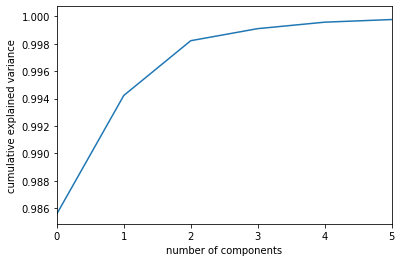

In [ ]:
pca = PCA().fit(traits_X)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlim(0, 5)
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [ ]:
pca = PCA(n_components=2)
pca.fit(traits_X)

In [ ]:
pca.components_.shape
X_pca = pca.transform(traits_X)

In [ ]:
plt.scatter(X_pca[:, 0], X_pca[:, 1],c=group,edgecolor='none', alpha=10)
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();

##replace NAN with means

In [ ]:
dt_x_replaced =  dt_merged_dropfeatures[dt_merged_dropfeatures.columns[13:]]


In [ ]:
##replace NA with mean
for (columnName, columnData)  in dt_x_replaced.iteritems():
  dt_x_replaced.update(dt_x_replaced[str(columnName)].fillna(value=dt_x_replaced[str(columnName)].mean(), inplace=True))

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:4536: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


In [ ]:
##replace NA with 0
for (columnName, columnData)  in dt_x_replaced.iteritems():
  dt_x_replaced.update(dt_x_replaced[str(columnName)].fillna(value=0, inplace=True))

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:4536: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


In [ ]:
 dt_x_replaced

,SG60C_AVG,SG100C_AVG,SG60C_SEM,SG100C_SEM,SG60C_N,SG100C_N,WSG_CHAVE,FRUIT_FRSH,FRUIT_DRY,N_SEEDFULL,N_SEEDEMPTY,DSPR_FRESH,DSPR_DRY,SEED_FRESH,SEED_DRY,N_INDS,N_FRUIT,N_DIASPORE,N_SEEDS,DBH_AVG,HEIGHT_AVG,DIAM_AVG,DBH_SEM,HEIGHT_SEM,DIAM_SEM,DBH_N,HEIGHT_N,DIAM_N,LEAFAREA_AVD,LEAFTHCK_AVD,LMADISC_AVD,LMALEAF_AVD,LMALAM_AVD,LDDISC_AVD,LDMC_AVD,LEAFAREA_SED,LEAFTHCK_SED,LMADISC_SED,LMALEAF_SED,LMALAM_SED,...,LDDISC_ND,LDMC_ND,LEAFAREA_AVI,LEAFTHCK_AVI,LMADISC_AVI,LMALEAF_AVI,LMALAM_AVI,LDDISC_AVI,LDMC_AVI,LEAFAREA_SEI,LEAFTHCK_SEI,LMADISC_SEI,LMALEAF_SEI,LMALAM_SEI,LDDISC_SEI,LDMC_SEI,LEAFAREA_NI,LEAFLET_NI,LEAFTHCK_NI,LMADISC_NI,LMALEAF_NI,LMALAM_NI,LDDISC_NI,LDMC_NI,AVG_LAMTUF,AVG_VEINTUF,SEM_LAMTUF,SEM_VEINTUF,N_LAMTUF,N_VEINTUF,RGR_10,N_RGR10,RGR_50,N_RGR50,RGR_100,N_RGR100,MORT_10,N_MORT10,MORT_100,N_MORT100
0,0.603363,0.612492,0.015698,0.012126,7.0,4.0,0.579633,303.669090,107.036985,11.801587,2.436508,14.237050,6.042451,13.109680,5.661719,9.000000,25.000000,100.000000,100.00,403.000000,20.570104,4.282793,10.885771,0.999090,0.680803,5.0,5.0,5.0,219.043368,201.250000,71.729602,98.664914,90.893253,0.352614,0.393561,53.581141,6.918005,9.976789,8.662941,8.454070,...,4.000000,0.000000,175.892500,153.055556,44.691691,55.193691,52.473080,0.290705,0.262537,31.415197,8.969255,3.723955,4.950322,4.926514,0.011016,0.011168,6.0,0.0,6.0,6.0,6.0,6.0,6.0,6.0,809.847059,3244.725000,332.784849,182.226245,17.0,16.0,3.171343,134.0,0.849488,502.0,0.452798,3025.0,2.453012,855.0,0.579736,3207.0
1,0.383251,0.407319,0.034080,0.036372,2.0,3.0,0.416009,15.248587,4.577899,1.000000,0.000000,3.363653,2.215282,2.252516,1.580256,9.000000,49.000000,49.000000,25.00,858.000000,37.272328,7.590143,33.713499,2.384359,0.161218,5.0,5.0,5.0,60.188333,252.083333,103.731176,104.975180,102.379490,0.413782,0.317615,5.948333,11.812090,6.385528,4.986949,4.749220,...,4.000000,2.000000,157.314000,171.833333,49.539222,57.462886,55.770514,0.289342,0.280287,33.646110,6.326751,3.215738,2.969252,2.889337,0.019590,0.005842,5.0,0.0,5.0,5.0,5.0,5.0,5.0,5.0,350.000000,2168.608333,32.516947,168.496581,12.0,12.0,2.736978,178.0,1.605094,170.0,1.424464,601.0,3.365947,418.0,2.014498,825.0
2,0.558785,0.468115,0.015583,0.033083,2.0,5.0,0.453960,4.993971,1.258512,1.602857,0.217143,0.792974,0.321729,0.210806,0.079972,5.000000,32.000000,71.000000,37.00,934.333333,33.493370,6.274246,30.339926,1.030341,0.608570,6.0,6.0,6.0,76.207333,216.944444,75.597513,78.067324,74.976901,0.349750,0.362014,9.890943,13.322333,4.608477,7.542857,7.420669,...,6.000000,5.000000,94.917222,180.000000,47.838466,50.554808,48.935755,0.267650,0.291754,20.863593,13.228757,1.224828,1.743246,1.796461,0.013470,0.001949,3.0,0.0,3.0,3.0,3.0,3.0,3.0,3.0,466.276471,2930.235294,33.353852,117.831958,17.0,17.0,1.766322,5202.0,1.232564,1884.0,0.929572,2585.0,1.421807,8064.0,1.225062,3535.0
3,0.595889,0.586264,0.019915,0.015440,4.0,5.0,0.570291,4.657143,1.145760,2.428571,0.685714,0.404341,0.192849,0.166455,0.098637,7.000000,35.000000,73.000000,60.00,396.833333,20.482320,5.664821,40.548257,1.775873,0.523137,6.0,6.0,6.0,371.740000,196.333333,92.402787,122.988133,99.682390,0.473372,0.467823,53.581141,5.901977,4.029963,8.662941,8.454070,...,5.000000,1.000000,588.635000,187.083333,59.901101,83.504675,68.728548,0.331809,0.414863,106.213026,12.523589,4.934192,9.634629,7.488312,0.042000,0.021539,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,618.453846,5159.546154,44.397946,461.406928,13.0,13.0,2.161820,9144.0,1.502480,1490.0,0.814889,1575.0,1.566259,12404.0,1.680846,1830.0
4,0.665530,0.691553,0.000128,0.068229,2.0,5.0,0.627189,1.493470,0.521049,1.700000,0.025000,0.278668,0.134250,0.181655,0.109507,8.000000,50.000000,110.000000,83.00,601.666667,29.346727,6.051033,12.563616,0.930539,0.686937,6.0,6.0,5.0,179.805000,240.000000,94.852776,115.535331,102.185768,0.394153,0.428716,70.089707,12.490737,7.338077,12.638023,10.554336,...,4.000000,4.000000,229.644667,179.000000,57.833221,73.021853,61.359181,0.323741,0.356269,20.625024,7.850159,2.028725,2.358904,2.10

In [ ]:
traits_X_replaced = dt_x_replaced.to_numpy()
group_replaced= dt_merged_dropfeatures['community']

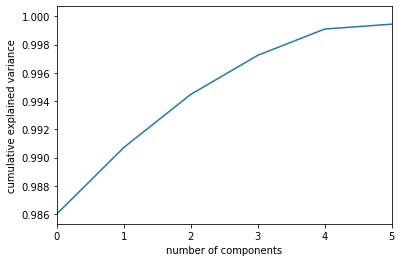

In [ ]:
pca = PCA().fit(traits_X_replaced)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlim(0, 5)
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [ ]:
pca = PCA(n_components=2)
pca.fit(traits_X_replaced)
X_pca = pca.transform(traits_X_replaced)

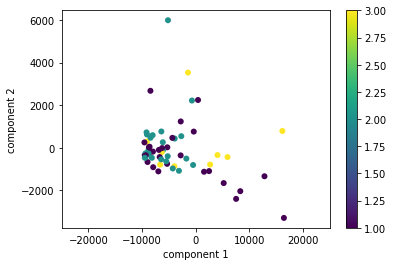

In [ ]:
plt.scatter(X_pca[:, 0], X_pca[:, 1],c=group_replaced,edgecolor='none', alpha=10)
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.xlim(-25000, 25000)
plt.colorbar();

#neural net

In [ ]:
ohe = OneHotEncoder()
ohe.fit(group_replaced.to_numpy().reshape(-1,1))
group = ohe.transform(group_replaced.to_numpy().reshape(-1,1)).toarray()


In [ ]:
traits_X_replaced.shape

(65, 88)

In [ ]:
##huffle the data set
X, Y = shuffle(traits_X_replaced, group, random_state = 0)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=1/5.0, random_state=0)

In [ ]:
# Let's look at the shape of our data thus far
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

X_train shape: (52, 88)
X_test shape: (13, 88)
y_train shape: (52, 3)
y_test shape: (13, 3)


In [ ]:
del dense_simple_model

In [ ]:
def kappa_loss(y_pred, y_true, y_pow=2, eps=1e-10, N=3, bsize=256, name='kappa'):
# A continuous differentiable approximation of discrete kappa loss.
#     Args:
#         y_pred: 2D tensor or array, [batch_size, num_classes]
#         y_true: 2D tensor or array,[batch_size, num_classes]
#         y_pow: int,  e.g. y_pow=2
#         N: typically num_classes of the model
#         bsize: batch_size of the training or validation ops
#         eps: a float, prevents divide by zero
#         name: Optional scope/name for op_scope.
#     Returns:
#         A tensor with the kappa loss.

  with tf.name_scope(name):
      y_true = tf.cast(y_true,dtype='float')
      repeat_op = tf.cast(tf.tile(tf.reshape(tf.range(0, N), [N, 1]), [1, N]), dtype='float')
      repeat_op_sq = tf.square((repeat_op - tf.transpose(repeat_op)))
      weights = repeat_op_sq / tf.cast((N - 1) ** 2, dtype='float')

      pred_ = y_pred ** y_pow
      try:
          pred_norm = pred_ / (eps + tf.reshape(tf.reduce_sum(pred_, 1), [-1, 1]))
      except Exception:
          pred_norm = pred_ / (eps + tf.reshape(tf.reduce_sum(pred_, 1), [bsize, 1]))

      hist_rater_a = tf.reduce_sum(pred_norm, 0)
      hist_rater_b = tf.reduce_sum(y_true, 0)

      conf_mat = tf.matmul(tf.transpose(pred_norm), y_true)

      nom = tf.reduce_sum(weights * conf_mat)
      denom = tf.reduce_sum(weights * tf.matmul(
          tf.reshape(hist_rater_a, [N, 1]), tf.reshape(hist_rater_b, [1, N])) /
                            tf.cast(bsize, dtype='float'))

      return nom / (denom + eps)
lossMetric = kappa_loss


In [ ]:
from sklearn.metrics import cohen_kappa_score
dense_simple_model = tf.keras.Sequential([
              tf.keras.layers.Dense(88, activation='relu'),
              tf.keras.layers.Dropout(.2),
              tf.keras.layers.Dense(20, activation='relu'),
              tf.keras.layers.Dropout(0.2),
              tf.keras.layers.Dense(3,activation='sigmoid')])
dense_simple_model.compile(loss=kappa_loss, optimizer='adam',metrics = kappa_loss)


In [ ]:
dense_simple_history = dense_simple_model.fit(X_train, y_train, epochs=60, validation_batch_size = 0.2,verbose=1)

Epoch 1/60
2/2 [==============================] - 1s 8ms/step - loss: 0.6001 - kappa_loss: 0.6264
Epoch 2/60
2/2 [==============================] - 0s 3ms/step - loss: 0.7860 - kappa_loss: 0.8485
Epoch 3/60
2/2 [==============================] - 0s 4ms/step - loss: 0.7728 - kappa_loss: 0.8040
Epoch 4/60
2/2 [==============================] - 0s 4ms/step - loss: 0.8015 - kappa_loss: 0.8208
Epoch 5/60
2/2 [==============================] - 0s 4ms/step - loss: 0.7741 - kappa_loss: 0.8187
Epoch 6/60
2/2 [==============================] - 0s 4ms/step - loss: 0.7401 - kappa_loss: 0.8045
Epoch 7/60
2/2 [==============================] - 0s 5ms/step - loss: 0.6371 - kappa_loss: 0.6564
Epoch 8/60
2/2 [==============================] - 0s 5ms/step - loss: 0.7680 - kappa_loss: 0.8074
Epoch 9/60
2/2 [==============================] - 0s 5ms/step - loss: 0.6647 - kappa_loss: 0.7058
Epoch 10/60
2/2 [==============================] - 0s 5ms/step - loss: 0.8084 - kappa_loss: 0.8701
Epoch 11/60
2/2 [==

In [ ]:
dense_cost = dense_simple_model.evaluate(X_test, y_test)[0]

In [ ]:
dense_simple_model.predict(X_train)

neuro net with PCA

In [ ]:
X, Y = shuffle(X_pca, group, random_state = 0)
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=1/5.0, random_state=0)

In [ ]:
del dense_simple_model

In [ ]:
dense_simple_model = tf.keras.Sequential([
              tf.keras.layers.Dense(8, activation='relu'),
              tf.keras.layers.Dropout(.2),
              tf.keras.layers.Dense(4, activation='relu'),
              tf.keras.layers.Dropout(0.2),
              tf.keras.layers.Dense(3,activation='sigmoid')])
dense_simple_model.compile(loss=tf.keras.losses.CategoricalCrossentropy(), optimizer='adam', metrics=['accuracy'])


In [ ]:
dense_simple_history = dense_simple_model.fit(X_train, y_train, epochs=60, validation_batch_size = 0.2,verbose=1)

##Conclusion

In this project, we investigated the spatial clustering of trees in BCI. We found three different clusters of species in the forest by applying distanced-based clustering method.
Our investigation found that the distribution of these three clusters of trees can be well predicted by feeding soil nutrients data to the neuro network, which implies the distinction of nutrients preference across these groups. And further on shows evidence of ecological/nice similarities within groups, and dissimilarities across groups. 